In [ ]:
# librerie
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# configurazione
image_size = 224 # dimensione a cui ridimensionare ogni immagine
batch_size = 32  # batch size per i DataLoader
n_components = 2342 # componenti principali che spiegano l 95% della soglia
noise_std = 0.05
# valori diversi di noise_std provati [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test
epochs = 100 # epoche training

pretty_labels = ['adenocarcinoma', 'beigno', 'carcinoma squamoso']  # nomi delle classi più leggibili

In [ ]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
# percorso per salvare output
output_folder = os.path.join(base_dir, "pca_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
log_txt_path = os.path.join(output_folder, "classification_reports.txt")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_{noise_std}.pth')
experiment_name = os.path.splitext(os.path.basename(save_path))[0]

In [ ]:
# caricamento dati
data_dict = torch.load(save_path, weights_only=False) # dati pre-elaborati (PCA) salvati in precedenza
X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

C:\Users\giken\AppData\Local\Temp\ipykernel_9692\743344398.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


In [35]:
# data_loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [ ]:
# modello flessibile
class FlexibleNet(nn.Module):  # rete neurale FC, configurabile (layer, dropout, batchnorm)
    def __init__(self, input_dim, hidden_dims, output_dim, use_batchnorm=False, dropout=0.0):
        super().__init__()
        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
def specificity_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    specificities = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities.append(specificity)

    if average == 'macro':
        return np.mean(specificities)
    elif average == 'none':
        return specificities
    else:
        raise ValueError("average must be 'macro' or 'none'")

In [37]:
# funzione di training
def train_model(model, train_loader, val_loader, criterion, optimizer, use_early_stopping=True, patience=10):
    best_val_loss = float('inf')
    trigger_times = 0
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            correct += (output.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = 100 * correct / total

        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping triggered.")
                    break

    if use_early_stopping:
        model.load_state_dict(best_model_state)
    return model, history

In [ ]:
results = []
summary = []

# funzione di cross-validation
def cross_validate_model(config, X_data, y_data, k=5, config_id=None):
    print(f"\n🔁 Cross-validation model: {config}")
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    all_y_true, all_y_pred = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data), 1):
        print(f"\n📂 Fold {fold}/{k}")
        X_train_cv, y_train_cv = X_data[train_idx], y_data[train_idx]
        X_val_cv, y_val_cv = X_data[val_idx], y_data[val_idx]

        train_loader_cv = DataLoader(TensorDataset(X_train_cv, y_train_cv), batch_size=batch_size, shuffle=True)
        val_loader_cv = DataLoader(TensorDataset(X_val_cv, y_val_cv), batch_size=batch_size)

        model = FlexibleNet(n_components, config['hidden_dims'], len(pretty_labels),
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        model, _ = train_model(model, train_loader_cv, val_loader_cv, criterion, optimizer,
                               use_early_stopping=config['early_stopping'])

        model.eval()
        y_true_fold, y_pred_fold = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader_cv:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true_fold.extend(y_batch.tolist())
                y_pred_fold.extend(preds.tolist())

        acc = 100 * np.mean(np.array(y_true_fold) == np.array(y_pred_fold))
        fold_accuracies.append(acc)
        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        report_fold = classification_report(y_true_fold, y_pred_fold, target_names=pretty_labels)
        print(f"Fold {fold} Accuracy: {acc:.2f}%")
        print(report_fold)

        fold_title = f"[{experiment_name}] Config {config_id} - Fold {fold}"
        with open(log_txt_path, "a") as f:
            f.write(f"{fold_title}\n{report_fold}\n")
            f.write(f"Fold Accuracy: {acc:.2f}%\n")
            f.write("-" * 80 + "\n")

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    precision = precision_score(all_y_true, all_y_pred, average='macro')
    recall = recall_score(all_y_true, all_y_pred, average='macro')
    f1 = f1_score(all_y_true, all_y_pred, average='macro')
    specificity_macro = specificity_score(all_y_true, all_y_pred)

    final_title = f"[{experiment_name}] Config {config_id} - SUMMARY"
    with open(log_txt_path, "a") as f:
        f.write(f"{final_title}\n")
        f.write(f"Mean Fold Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}\n")
        f.write("=" * 100 + "\n")

    print(f"\n✅ Config {config_id} - CV Mean Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

    cumulative_cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cumulative_cm, annot=True, fmt='d',
                xticklabels=pretty_labels,
                yticklabels=pretty_labels,
                cmap='Blues')
    plt.title("Confusion Matrix cumulativa")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cumulative_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_cumulative_config_{config_id}.png")
    plt.savefig(cumulative_path)
    plt.close()

    summary.append({
        'config_id': config_id,
        'hidden_dims': config['hidden_dims'],
        'dropout': config['dropout'],
        'batchnorm': config['batchnorm'],
        'early_stopping': config['early_stopping'],
        'cross_val': True,
        'accuracy': mean_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity_macro,
        'conf_matrix': cumulative_cm.tolist()
    })


In [ ]:
configurations = [
    {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [128], 'batchnorm': False, 'dropout': 0.1, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [128, 64], 'batchnorm': False, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [128, 64], 'batchnorm': True, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    {'hidden_dims': [1024, 512, 256, 128, 64, 32, 16], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
]

In [ ]:
for i, config in enumerate(configurations, 1):
    print(f"\n[{experiment_name}] Config {i}: {config}")
    if config.get("cross_val", False):
        cross_validate_model(config, torch.cat([X_train, X_val]), torch.cat([y_train, y_val]), k=5, config_id=i)
    else:
        model = FlexibleNet(n_components, config['hidden_dims'], len(pretty_labels),
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        model, history = train_model(model, train_loader, val_loader, criterion, optimizer,
                                     use_early_stopping=config['early_stopping'])

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true.extend(y_batch.tolist())
                y_pred.extend(preds.tolist())

        test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        report_txt = classification_report(y_true, y_pred, target_names=pretty_labels)
        cm = confusion_matrix(y_true, y_pred)
        specificity_macro = specificity_score(y_true, y_pred, average='macro')
        specificity_per_class = specificity_score(y_true, y_pred, average='none')

        print(report_txt)
        print("Confusion Matrix:")
        print(cm)
        print(f"Specificity (macro): {specificity_macro:.4f}")
        for label, spec in zip(pretty_labels, specificity_per_class):
            print(f"Specificity [{label}]: {spec:.4f}")

        title = f"[{experiment_name}] Config {i}"
        with open(log_txt_path, "a") as f:
            f.write(f"{title}\nTest Accuracy: {test_acc:.2f}%\n")
            f.write(report_txt + "\n")
            f.write("Confusion Matrix:\n" + np.array2string(cm) + "\n")
            f.write("Specificities:\n")
            for label, spec in zip(pretty_labels, specificity_per_class):
                f.write(f"{label}: {spec:.4f}\n")
            f.write("="*80 + "\n")

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels, yticklabels=pretty_labels, cmap='Blues')
        plt.title(f"{title} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(os.path.join("pca_outputs", f"{experiment_name}_conf_matrix_config_{i}.png"))
        plt.show()

        summary.append({
            'config_id': i,
            'hidden_dims': config['hidden_dims'],
            'dropout': config['dropout'],
            'batchnorm': config['batchnorm'],
            'early_stopping': config['early_stopping'],
            'cross_val': False,
            'accuracy': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity_macro,
            'specificity_per_class': specificity_per_class,
            'conf_matrix': cm.tolist()
        })


[pca_data_2342_0.05] Config 1: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

🔁 Cross-validation model: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

📂 Fold 1/5
Epoch 01 | Train Acc: 67.25% | Val Acc: 71.02%
Epoch 02 | Train Acc: 85.03% | Val Acc: 71.26%
Epoch 03 | Train Acc: 91.14% | Val Acc: 72.46%
Epoch 04 | Train Acc: 94.77% | Val Acc: 72.23%
Epoch 05 | Train Acc: 96.92% | Val Acc: 71.88%
Epoch 06 | Train Acc: 95.93% | Val Acc: 71.37%
Epoch 07 | Train Acc: 95.67% | Val Acc: 68.89%
Epoch 08 | Train Acc: 97.16% | Val Acc: 71.72%
Epoch 09 | Train Acc: 99.24% | Val Acc: 71.68%
Epoch 10 | Train Acc: 99.89% | Val Acc: 71.96%
Epoch 11 | Train Acc: 100.00% | Val Acc: 71.92%
Early stopping triggered.
Fold 1 Accuracy: 71.92%
                    precision    recall  f1-score   support

    adenocarcinoma       0.62      0.62      0.62       861
           benigno       0.87      0.8

In [48]:
summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join("pca_outputs", f"{experiment_name}_summary.csv"), index=False)

with open(os.path.join("pca_outputs", f"{experiment_name}_summary.txt"), 'w') as f:
    for row in summary:
        f.write(f"Config {row['config_id']} | Acc: {row['accuracy']:.2f}% | Dropout: {row['dropout']} | Layers: {row['hidden_dims']}\n")

In [ ]:
print(summary_df.columns)

Index(['config_id', 'hidden_dims', 'dropout', 'batchnorm', 'early_stopping',
       'cross_val', 'accuracy', 'precision', 'recall', 'f1_score',
       'conf_matrix'],
      dtype='object')


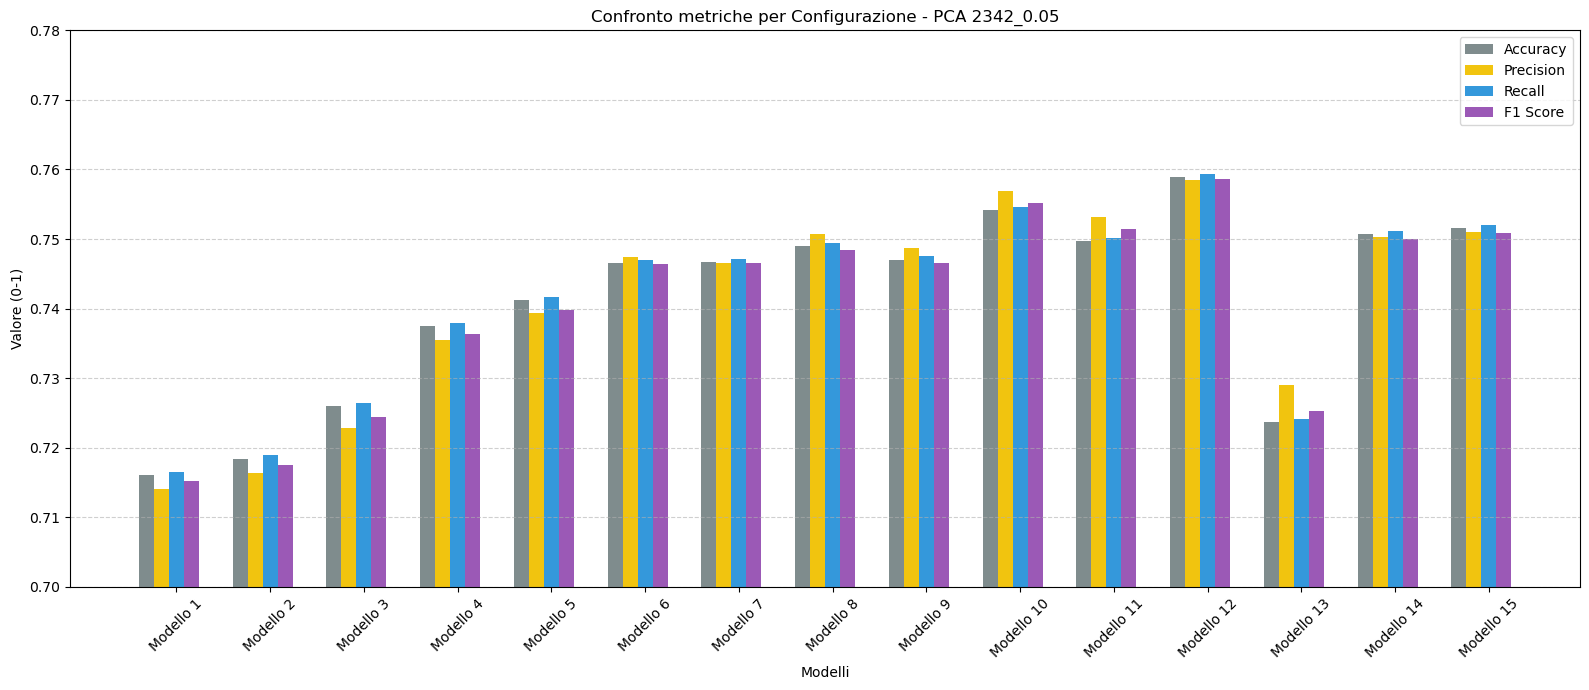

In [ ]:
# plot confronto metriche diversi reti
bar_width = 0.16  # ridotto per far entrare 5 metriche
x = np.arange(len(summary_df))


plt.figure(figsize=(16, 7))
plt.bar(x - 2 * bar_width, summary_df['accuracy']/100, width=bar_width, label='Accuracy', color='#7F8C8D')     # grigio
plt.bar(x - 1 * bar_width, summary_df['precision'], width=bar_width, label='Precision', color='#F1C40F')     # oro pallido
plt.bar(x, summary_df['recall'], width=bar_width, label='Recall', color='#3498DB')                           # blu pastello
plt.bar(x + 1 * bar_width, summary_df['f1_score'], width=bar_width, label='F1 Score', color='#9B59B6')       # lilla soft
plt.bar(x + 2 * bar_width, summary_df['specificity'], width=bar_width, label='Specificity', color='#95A5A6')  # grigio chiaro


plt.xlabel("Modelli")
plt.ylabel("Valore (0-1)")
plt.title(f"Confronto metriche per Configurazione - PCA {n_components}_{noise_std}")
plt.xticks(x, [f"Modello {cid}" for cid in summary_df['config_id']], rotation=45)
plt.ylim(0.7, 0.78)
plt.legend()
plt.yticks(np.arange(0.7, 0.78, 0.01))  # ogni 0.01 tra 0.7 e 0.8
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()